In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1


In [ ]:
image_path = os.path.join(dataset_path, "images", "images")
print("Image directory:", image_path)

# Verify if the path exists
if os.path.exists(image_path):
    print("Images found:", os.listdir(image_path)[:10])  # Show first 10 images
else:
    print("Path does not exist. Check dataset structure.")


Image directory: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images/images/images
Path does not exist. Check dataset structure.


In [ ]:

class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:

dataset_path = '/root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images/'
batch_size = 32
num_epochs = 5
learning_rate = 0.001

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = WasteDataset(dataset_path, split='train', transform=transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Create the model, loss function, and optimizer
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)


        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)


            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training completed!")


Epoch [1/5], Train Loss: 3.2550, Train Acc: 19.64%, Val Loss: 2.0835, Val Acc: 43.73%
Epoch [2/5], Train Loss: 1.6438, Train Acc: 55.67%, Val Loss: 1.1041, Val Acc: 71.67%
Epoch [3/5], Train Loss: 0.5237, Train Acc: 86.44%, Val Loss: 0.9044, Val Acc: 78.87%
Epoch [4/5], Train Loss: 0.2369, Train Acc: 94.16%, Val Loss: 0.8733, Val Acc: 80.37%
Epoch [5/5], Train Loss: 0.1600, Train Acc: 95.60%, Val Loss: 0.7991, Val Acc: 81.47%
Training completed!


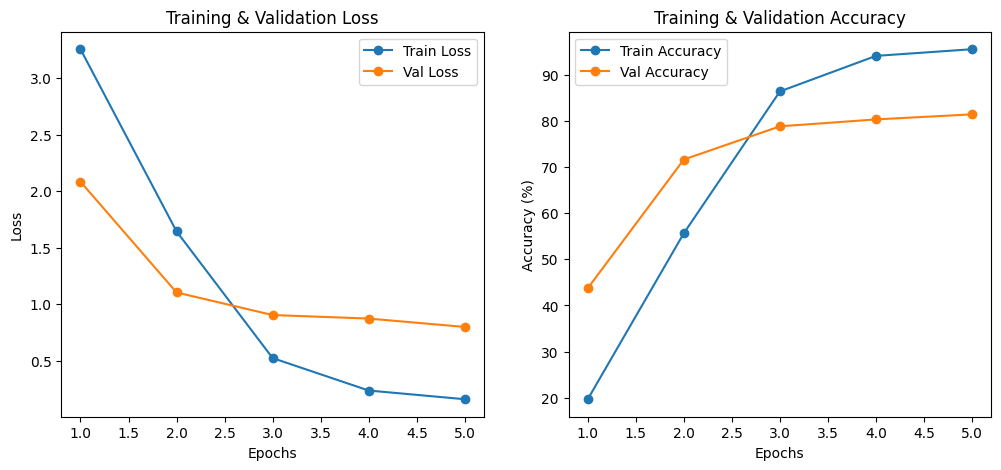

In [ ]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Val Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()

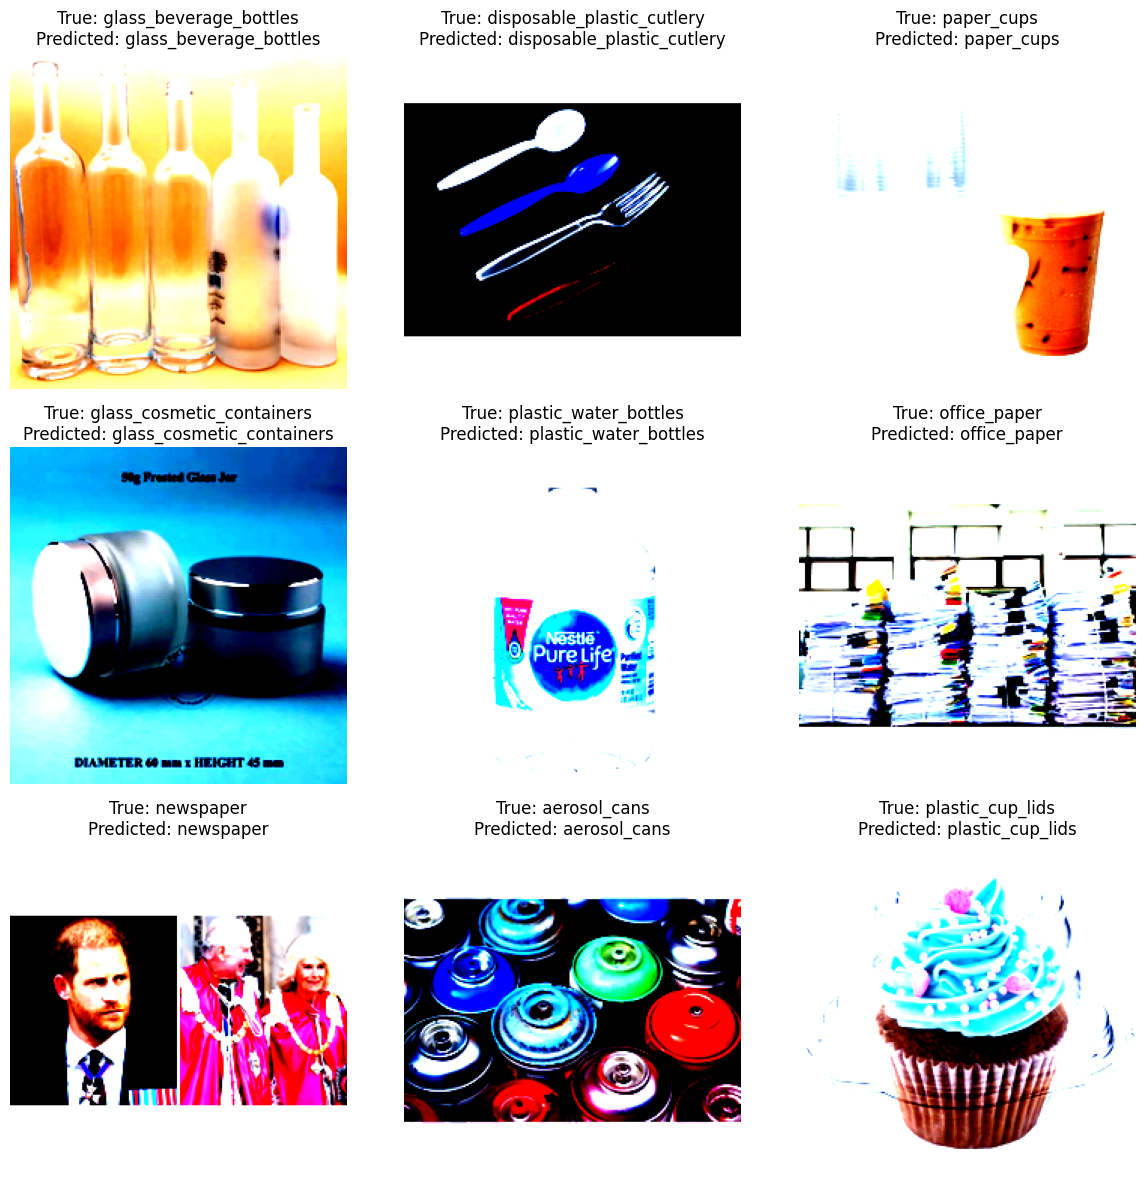

In [ ]:

model.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)

    selected_images = []
    selected_labels = []
    selected_predicted = []

    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')

        output = model(image)
        _, predicted = torch.max(output, 1)

        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())

        if len(selected_labels) == 9:
            break

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        axes[i].set_title(f"True: {train_dataset.classes[selected_labels[i]]}\nPredicted: {train_dataset.classes[selected_predicted[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import torch
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer

def load_nlp_model():
    """Loads a pre-trained NLP model for waste-to-energy conversion explanations."""
    model_name = "facebook/bart-large-cnn"
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)
    return summarizer


conversion_methods = {
    "plastic water bottle": "Plastic bottles can be processed using pyrolysis to generate fuel oils or incinerated for energy recovery.",
    "shopping bag": "Plastic shopping bags can be melted and converted into synthetic fuels using pyrolysis.",
    "cardboard box": "Cardboard can be burned in waste-to-energy plants to produce electricity or converted into bioethanol.",
    "newspaper": "Old newspapers can be pulped for biogas production or used in biomass combustion for energy.",
    "glass bottle": "Glass itself doesn't produce energy but recycling it saves energy that would be needed to manufacture new glass.",
    "aluminum can": "Recycling aluminum cans saves 95% of the energy required to make new cans from raw materials.",
    "steel can": "Recycling steel cans reduces the need for energy-intensive iron ore extraction.",
    "banana peel": "Organic waste like banana peels can be used in anaerobic digestion to produce biogas.",
    "coffee grounds": "Used coffee grounds can be converted into biofuel or burned for heat generation.",
    "cotton shirt": "Textile waste like cotton can undergo pyrolysis to generate biochar and synthetic fuels.",
    "old shoes": "Shoes made from rubber and synthetic materials can be used in waste-to-energy incineration or material recovery.",
    "electronic waste": "E-waste undergoes pyrolysis to extract valuable metals and convert plastic parts into fuel.",
    "food scraps": "Food waste can be composted or anaerobically digested to generate methane for energy.",
    "wooden furniture": "Wood waste can be processed into biomass pellets for combustion in power plants.",
    "rubber tire": "Old tires can be converted into synthetic gas or oil through pyrolysis.",
    "milk carton": "Milk cartons, made of paper and plastic, can be used in waste-to-energy combustion or separated for recycling.",
    "straw": "Plastic straws can be melted and processed into low-grade fuel products.",
    "disposable cutlery": "Plastic cutlery can undergo pyrolysis to be converted into fuel oils.",
    "tea bag": "Tea bags can be composted or processed in anaerobic digestion for biogas generation.",
    "cosmetic container": "Glass cosmetic containers should be recycled, conserving energy needed for new glass production."
}

def waste_to_energy(waste_item, summarizer):
    """Takes a waste item as input and returns an energy conversion method."""
    waste_item_lower = waste_item.lower()
    response = conversion_methods.get(waste_item_lower, "No specific energy conversion method found.")
    summary = summarizer(response, max_length=50, min_length=10, do_sample=False)
    return summary[0]['summary_text']

summarizer = load_nlp_model()


def test_model():
    test_inputs = list(conversion_methods.keys())  # Now accessible here
    for item in test_inputs:
        print(f"{item}: {waste_to_energy(item, summarizer)}\n")


test_model()

Device set to use cuda:0
Your max_length is set to 50, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 50, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


plastic water bottle: Plastic bottles can be processed using pyrolysis to generate fuel oils or incinerated for energy recovery.



Your max_length is set to 50, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


shopping bag: Plastic shopping bags can be melted and converted into synthetic fuels using pyrolysis.



Your max_length is set to 50, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


cardboard box: Cardboard can be burned in waste-to-energy plants to produce electricity or converted into bioethanol.



Your max_length is set to 50, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


newspaper: Old newspapers can be pulped for biogas production or used in biomass combustion for energy.



Your max_length is set to 50, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


glass bottle: Glass itself doesn't produce energy but recycling it saves energy that would be needed to manufacture new glass.



Your max_length is set to 50, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


aluminum can: Recycling aluminum cans saves 95% of the energy required to make new cans from raw materials.



Your max_length is set to 50, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


steel can: Recycling steel cans reduces the need for energy-intensive iron ore extraction.



Your max_length is set to 50, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


banana peel: Organic waste like banana peels can be used in anaerobic digestion to produce biogas.



Your max_length is set to 50, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


coffee grounds: Used coffee grounds can be converted into biofuel or burned for heat generation.



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 50, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


cotton shirt: Textile waste like cotton can undergo pyrolysis to generate biochar and synthetic fuels.



Your max_length is set to 50, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


old shoes: Shoes made from rubber and synthetic materials can be used in waste-to-energy incineration or material recovery.



Your max_length is set to 50, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


electronic waste: E-waste undergoes pyrolysis to extract valuable metals and convert plastic parts into fuel.



Your max_length is set to 50, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


food scraps: Food waste can be composted or anaerobically digested to generate methane for energy.



Your max_length is set to 50, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


wooden furniture: Wood waste can be processed into biomass pellets for combustion in power plants.



Your max_length is set to 50, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


rubber tire: Old tires can be converted into synthetic gas or oil through pyrolysis.



Your max_length is set to 50, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


milk carton: Milk cartons can be used in waste-to-energy combustion or separated for recycling. Milk cartons are made of paper and plastic.



Your max_length is set to 50, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


straw: Plastic straws can be melted and processed into low-grade fuel products.



Your max_length is set to 50, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


disposable cutlery: Plastic cutlery can undergo pyrolysis to be converted into fuel oils.



Your max_length is set to 50, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


tea bag: Tea bags can be composted or processed in anaerobic digestion for biogas generation.

cosmetic container: Glass cosmetic containers should be recycled, conserving energy needed for new glass production.



In [ ]:
import torch
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import json
import random

# Load NLP Model
def load_nlp_model():
    """Loads a pre-trained NLP model for waste-to-energy conversion explanations."""
    model_name = "facebook/bart-large-cnn"
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)
    return summarizer

# Load Image Classification Model
def load_image_model():
    """Loads a pre-trained image classification model."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet50(pretrained=True).to(device)
    model.eval()
    return model

# Preprocess Image
def preprocess_image(image):
    """Preprocesses an image for model prediction."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0)

# Hardcoded waste labels for testing (Replace this with actual ImageNet labels)
imagenet_labels = {
    "plastic bottle": "plastic water bottle",
    "banana": "banana peel",
    "carton": "cardboard box"
}

# Classify Waste
def classify_waste(image, model):
    """Classifies waste using an image model."""
    try:
        image_tensor = preprocess_image(image)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image_tensor = image_tensor.to(device)

        output = model(image_tensor)
        _, predicted = output.max(1)

        # Use hardcoded labels (assuming simple waste classes)
        waste_item = list(imagenet_labels.values())[predicted.item() % len(imagenet_labels)]
        return waste_item
    except Exception as e:
        return f"Error in image classification: {e}"

# Define Waste-to-Energy Methods
conversion_methods = {
    "plastic water bottle": "Plastic bottles can be processed using pyrolysis to generate fuel oils or incinerated for energy recovery.",
    "shopping bag": "Plastic shopping bags can be melted and converted into synthetic fuels using pyrolysis.",
    "cardboard box": "Cardboard can be burned in waste-to-energy plants to produce electricity or converted into bioethanol.",
    "banana peel": "Organic waste like banana peels can be used in anaerobic digestion to produce biogas.",
    "rubber tire": "Old tires can be converted into synthetic gas or oil through pyrolysis."
}

# NLP Summarization for Energy Conversion
def waste_to_energy(waste_item, summarizer):
    """Takes a waste item as input and returns an energy conversion method."""
    response = conversion_methods.get(waste_item, "No specific energy conversion method found.")
    summary = summarizer(response, max_length=50, min_length=10, do_sample=False)
    return summary[0]['summary_text']

# Load Models
summarizer = load_nlp_model()
image_model = load_image_model()

# Load Random Image from Local Storage
def get_random_image():
    """Loads a random image from Google Drive."""
    image_paths = [
        "/content/drive/MyDrive/plastic_bottle.jpg",
    ]
    try:
        image_path = random.choice(image_paths)
        image = Image.open(image_path).convert("RGB")
        return image
    except Exception as e:
        return f"Error loading image: {e}"

# Test Image Classification + NLP Pipeline
def test_combined_model():
    """Tests image recognition and NLP model together."""
    image = get_random_image()
    if isinstance(image, str):
        print(image)
        return

    classified_waste = classify_waste(image, image_model)
    if "Error" in classified_waste:
        print(classified_waste)
        return

    energy_conversion = waste_to_energy(classified_waste, summarizer)
    print(f"Detected Waste: {classified_waste}")
    print(f"Energy Conversion Method: {energy_conversion}")

# Run Tests
def run_tests():
    """Runs multiple test cases to validate the model."""
    for _ in range(3):
        print("Testing random image...")
        test_combined_model()
        print("----------------------------")

run_tests()


Device set to use cuda:0
Your max_length is set to 50, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Testing random image...


Your max_length is set to 50, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Detected Waste: banana peel
Energy Conversion Method: Organic waste like banana peels can be used in anaerobic digestion to produce biogas.
----------------------------
Testing random image...


Your max_length is set to 50, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Detected Waste: banana peel
Energy Conversion Method: Organic waste like banana peels can be used in anaerobic digestion to produce biogas.
----------------------------
Testing random image...
Detected Waste: banana peel
Energy Conversion Method: Organic waste like banana peels can be used in anaerobic digestion to produce biogas.
----------------------------
